In [ ]:
# %pip install tensorflow
# %pip install keras

# %pip install --upgrade keras
# %pip install --upgrade keras-cv
# %pip install --upgrade keras-hub
# %pip install --upgrade keras
# %pip install --upgrade typing_extensions


# Config for 1 or 2 Hidden Layers in the Neural Network | True = ON, False = OFF
Layer_ONE                       = True
Layer_TWO                       = True

KFOLD                           = 5
EPOCHS                          = 10
BATCH_SIZE                      = 128
SAVE_MODELS_AND_WEIGHTS         = False # Saves all Models&Weights in a folder from each KFold

HiddenLayer_ONE_Neurons         = 32
HiddenLayer_TWO_Neurons         = 16

Output_Neurons                  = 10   # Assuming MNIST digits: 10 output classes

# 0 = sigmoid, 1 = tanh, 2 = relu, 3 = leaky relu, 4 = softmax 
ChooseActivationFunction_ONE    = 0 
ChooseActivationFunction_TWO    = 2 
 
ChooseActivationFunction_OUTPUT = 4 



import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [311]:
# Lade das MNIST-Datenset und teile es in Trainings- und Testdaten auf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Prüfe, ob die Datensätze die erwarteten Formen haben
assert x_train.shape == (60000, 28, 28) # Input 
assert x_test.shape == (10000, 28, 28)  # Input
assert y_train.shape == (60000,)        # Feature/Label
assert y_test.shape == (10000,)         # Feature/Label
    
    
# Erstelle ein tf.data.Dataset aus dem Trainingsdatensatz
# Dabei werden die Bilder und Labels als Dictionary abgelegt, um später über die Schlüssel zugreifen zu können
ds = tf.data.Dataset.from_tensor_slices({"image": x_train, "label": y_train})


In [312]:
def Layer_ONE_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

def Layer_TWO_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

def OUTPUT_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"


#------------------------------------------------------------------------------
# Model CONFIGURATION
#------------------------------------------------------------------------------
def create_model():
  if Layer_ONE:
    activation_one = Layer_ONE_ACTIVATION(ChooseActivationFunction_ONE)

  if Layer_TWO:
    activation_two = Layer_TWO_ACTIVATION(ChooseActivationFunction_TWO)

  if Output_Neurons: 
    activation_output = OUTPUT_ACTIVATION(ChooseActivationFunction_OUTPUT)


  # Build the model using the chosen activations
  layers = [
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Flatten()
  ]

  if Layer_ONE:
    layers.append(tf.keras.layers.Dense(HiddenLayer_ONE_Neurons, activation=activation_one))

  if Layer_TWO:
    layers.append(tf.keras.layers.Dense(HiddenLayer_TWO_Neurons, activation=activation_two))

  layers.append(tf.keras.layers.Dense(Output_Neurons, activation=activation_output))

  model = tf.keras.Sequential(layers)

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

  return model


if KFOLD:
  print("KFOLD")
  pass

if not KFOLD:
  print("NOT KFOLD")
  model = create_model()
  
  early_stop = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True
)

KFOLD


In [313]:
if KFOLD:
    kfold = KFold(n_splits=KFOLD, shuffle=True)
    fold_accuracies = []
    histories = []
    i = 0

    for train_idx, val_idx in kfold.split(x_train):
        model = create_model()                              # new model for this run
        early_stop = tf.keras.callbacks.EarlyStopping()     # new early stopping for this run
        
        x_train_fold, x_val_fold = x_train[train_idx]/255.0, x_train[val_idx]/255.0     # normalise the data
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]                 # get the labels

        history = model.fit(
            x_train_fold, y_train_fold,                     # traindata for this fold
            validation_data=(x_val_fold, y_val_fold),       # validation data for this fold
            epochs=EPOCHS,                                  # number of epochs to train
            batch_size=BATCH_SIZE,                          # after how many samples to update the weights
            callbacks=[early_stop]                          # backpropagation with early stopping
        )

  
        histories.append(history)  # Save the history object for later analysis
        
        loss, accuracy = model.evaluate(x_val_fold, y_val_fold) # Evaluate the model on the validation data
        
        fold_accuracies.append(accuracy)

        if SAVE_MODELS_AND_WEIGHTS:
          os.makedirs("Models", exist_ok=True)
          model.save(f"Models/saved_model_{i}.keras")
          model.save_weights(f"Models/saved_weights_{i}.weights.h5")
          i += 1
        
else:
  # Falls KFOLD nicht gesetzt ist (z.B. False oder 0), wird das Modell direkt auf den gesamten Trainingsdaten trainiert.
  history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))
  
  # Nach dem Training erfolgt die Evaluierung des Modells auf den Testdaten.
  loss, accuracy = model.evaluate(x_test, y_test)






Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5280 - loss: 1.5663 - val_accuracy: 0.8772 - val_loss: 0.5069
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8907 - loss: 0.4281 - val_accuracy: 0.9121 - val_loss: 0.3288
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9170 - loss: 0.2970 - val_accuracy: 0.9274 - val_loss: 0.2670
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9332 - loss: 0.2376 - val_accuracy: 0.9317 - val_loss: 0.2393
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9410 - loss: 0.2035 - val_accuracy: 0.9395 - val_loss: 0.2152
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9467 - loss: 0.1860 - val_accuracy: 0.9411 - val_loss: 0.2011
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9507 - loss: 0.1681 - val_accuracy: 0.9448 - val_loss: 0.1912
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9544 - loss: 0.1551 - val_accuracy: 0.

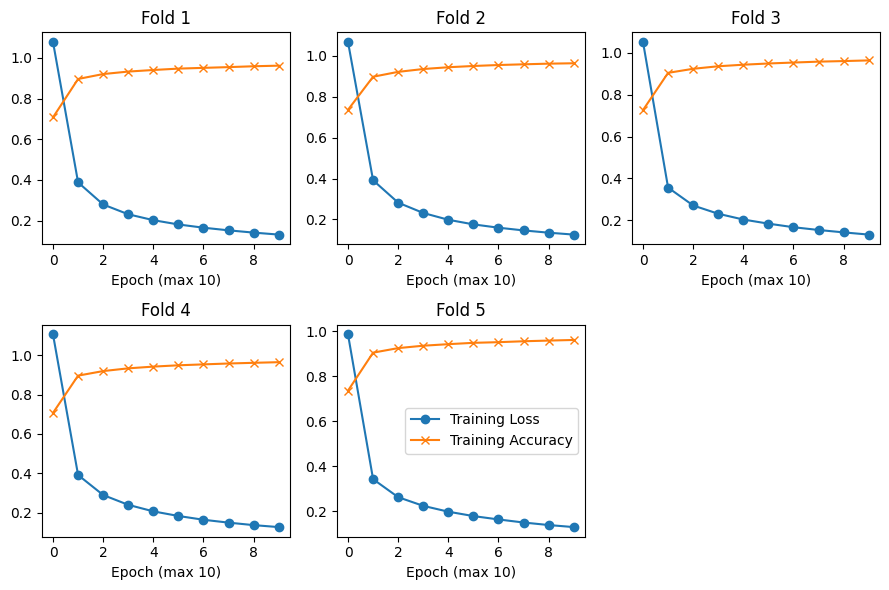

In [314]:

if KFOLD:
    n_folds = len(histories)
    if n_folds >= 5:
        cols = (n_folds + 1) // 2  
        rows = 2
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(1, n_folds, figsize=(n_folds * 3, 3))
        if n_folds == 1:
            axs = [axs]
    
    for i, hist in enumerate(histories):
        ax = axs[i]
        ax.plot(hist.history['loss'], marker='o', label='Training Loss')
        ax.plot(hist.history['accuracy'], marker='x', label='Training Accuracy')
        ax.set_xlabel(f'Epoch (max {EPOCHS})')
        ax.set_title(f'Fold {i+1}')
    
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
else:
    plt.figure(figsize=(3,2))
    plt.plot(history.history['loss'], marker='o', label='Training Loss')
    plt.plot(history.history['accuracy'], marker='x', label='Training Accuracy')
    plt.xlabel(f'Epoch (max {EPOCHS})')
    plt.title('Training Loss and Accuracy')
    plt.legend()
    plt.show()

In [315]:
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display


urls = [
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true"
]

for idx, url in enumerate(urls):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            print(f"Image {idx+1} loaded from: {url}")
            display(img)
            
            # Convert to grayscale and resize to 28x28
            img_proc = img.convert("L").resize((28, 28))
            
            # Prepare the image for the model: normalize and add dimensions
            img_arr = 1.0 - np.array(img_proc) / 255.0
            img_arr = img_arr.reshape(1, 28, 28, 1)
            
            # Get prediction from the model
            probs = model.predict(img_arr)
            pred_class = np.argmax(probs)
            
            print(f"Predicted class: {pred_class}")
            print(f"Probabilities: {probs}")
        else:
            print(f"Failed to load image {idx+1} from: {url} with status code {response.status_code}")
    except Exception as e:
        print(f"Error processing image {idx+1} from {url}: {e}")


Image 1 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted class: 3
Probabilities: [[2.6469861e-05 7.5999364e-05 5.8402166e-02 9.4067830e-01 1.8779792e-05
  3.4880778e-04 3.5525160e-04 2.0565461e-05 7.1660339e-05 1.9922438e-06]]
Image 2 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: 1
Probabilities: [[9.5713622e-06 4.3123063e-01 6.1734125e-02 1.8908615e-01 2.6519923e-04
  7.3315632e-03 5.4687302e-05 1.6216117e-01 6.7976467e-02 8.0150463e-02]]
Image 3 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: 3
Probabilities: [[1.3167564e-04 2.1511789e-02 6.6157386e-02 8.1669104e-01 2.6692405e-05
  2.7914653e-02 5.8976606e-02 1.2808022e-05 8.5271923e-03 5.0082785e-05]]
Image 4 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: 5
Probabilities: [[3.3839166e-03 2.3678573e-02 1.6012669e-01 3.8311411e-02 8.0966792e-04
  5.0088710e-01 1.8457274e-01 1.7672592e-05 8.8190898e-02 2.1384532e-05]]
